In [2]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params
from multi_group_dorm_simulation import MultiGroupDormSimulation

In [1]:
def init_dorm_sim(dorm_test_rate):
    return MultiGroupDormSimulation(
                num_dorms=100,
                dorm_population=8000,
                non_dorm_population=26000,
                intra_dorm_contacts=15, # 10 contacts/day within each dorm
                inter_dorm_contacts=5, #10 contacts/day with other people in dorms
                intra_non_dorm_contacts=3, # each person in a dorm has this many contacts/day with person not in a dorm
                inter_non_dorm_contacts=7.3, #contacts/day within non-dorm community
                dorm_test_rate=dorm_test_rate, # daily test rate within dorms
                non_dorm_test_rate=0.2, #daily test rate in non-dorm
                # set the following parameters to their non-quarantine counterparts
                quarantine_contacts_multiplier=1, # multiply contacts/day rates by this after dorm is quarantined
                quarantine_test_fraction=dorm_test_rate, # test fraction after dorm goes into quarantine
                dorm_outside_infection_p=None, # outside infections for people in dorms -- None means use default
                initial_dorm_prevalence = 0 # initial prevalence (percentage) in the dorms
    )

In [3]:
dorm_test_rates = [0.1, 0.2, 0.35, 0.5, 0.8]

quarantine_trajectories = {}
dorm_sims = {}

import time

for test_rate in dorm_test_rates:
    print("starting test_rate {}".format(test_rate))
    quarantine_trajectories[test_rate] = []
    dorm_sims[test_rate] = []

    start_time = time.time()
    
    for _ in range(5):
        sim = init_dorm_sim(test_rate)
        quarantine_trajectories[test_rate].append(sim.run_new_trajectory(112))
        dorm_sims[test_rate].append(sim)
        print("done new trajectory")
        
    end_time = time.time()
    print("test_rate {} took {} time".format(test_rate, end_time - start_time))

starting test_rate 0.1
done new trajectory
done new trajectory
done new trajectory
done new trajectory
done new trajectory
test_rate 0.1 took 2130.869861125946 time
starting test_rate 0.2
done new trajectory
done new trajectory
done new trajectory
done new trajectory
done new trajectory
test_rate 0.2 took 2151.3368768692017 time
starting test_rate 0.35
done new trajectory
done new trajectory
done new trajectory
done new trajectory
done new trajectory
test_rate 0.35 took 2164.0266387462616 time
starting test_rate 0.5
done new trajectory
done new trajectory
done new trajectory
done new trajectory
done new trajectory
test_rate 0.5 took 2163.992582321167 time
starting test_rate 0.8
done new trajectory
done new trajectory
done new trajectory
done new trajectory
done new trajectory
test_rate 0.8 took 2156.4504618644714 time


In [4]:
quarantine_trajectories.keys()

dict_keys([0.1, 0.2, 0.35, 0.5, 0.8])

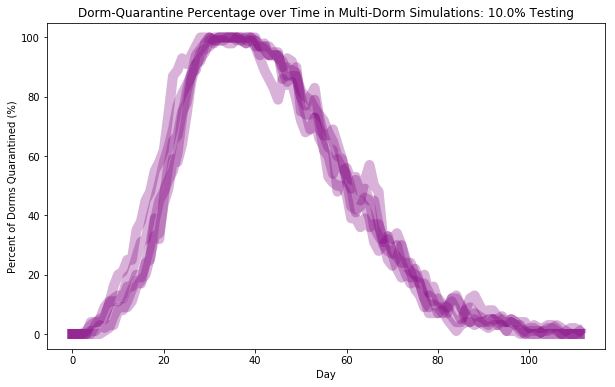

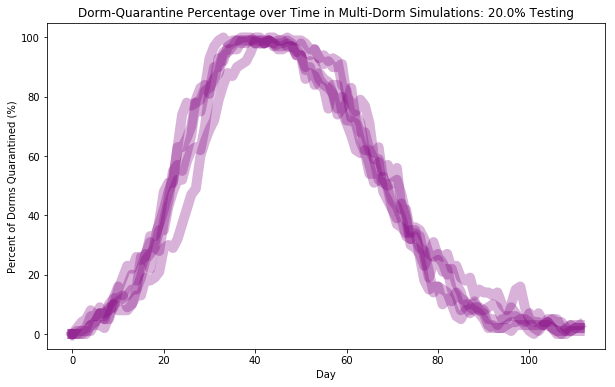

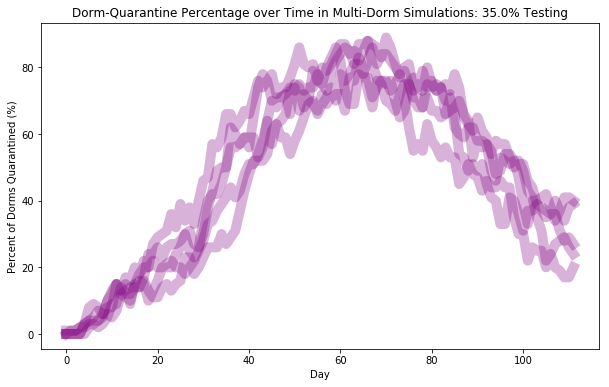

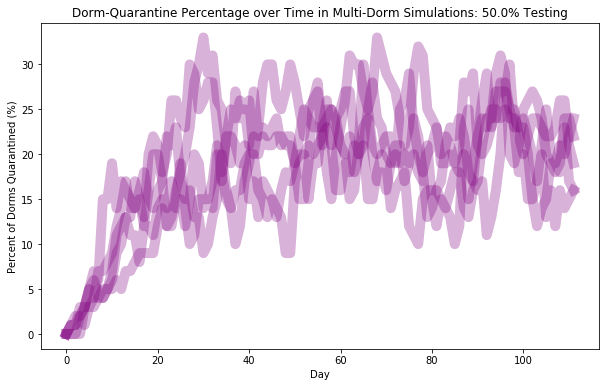

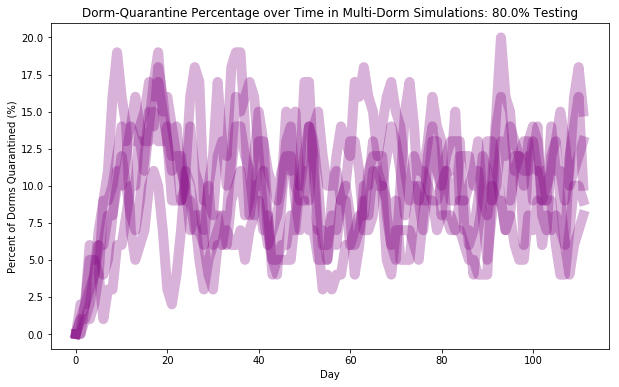

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dorm_quarantines(cs, test_rate):
    xs = list(range(112))
    plt.figure(figsize=(10,6))
    for c in cs:
        plt.plot(xs, c, color='purple', alpha=0.3, linewidth=10)
    plt.xlabel("Day")
    plt.ylabel("Percent of Dorms Quarantined (%)")
    plt.title("Dorm-Quarantine Percentage over Time in Multi-Dorm Simulations: {}% Testing".format(test_rate*100))
    plt.show()

for test_rate in dorm_test_rates:
    plot_dorm_quarantines(quarantine_trajectories[test_rate], test_rate)

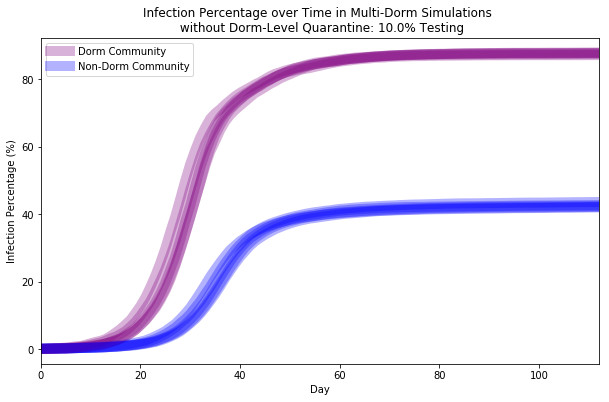

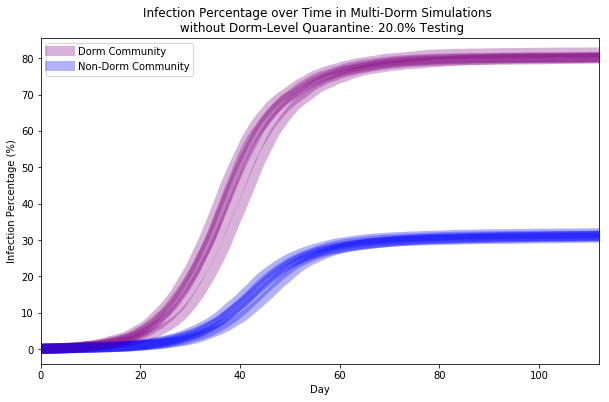

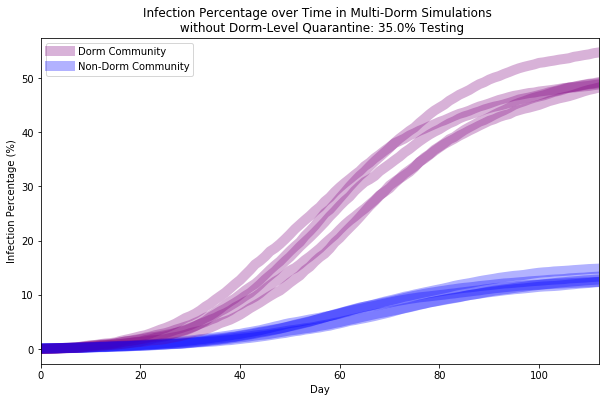

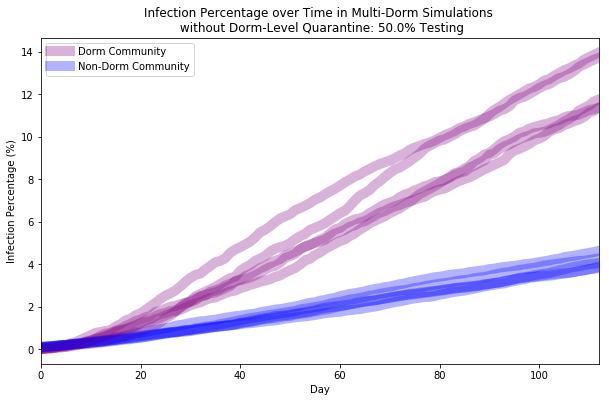

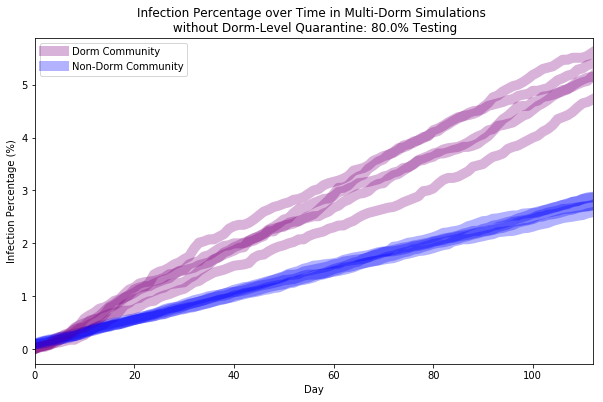

In [6]:
def get_popsize(df):
    cols = df.columns
    subdf = df[[col for col in cols if 'cumulative' not in col]]
    return subdf.sum(axis=1).iloc[0]

def infection_pct(df):
    popsize = get_popsize(df)
    
    subdf = df[['cumulative_mild', 'cumulative_severe']]
    infections = subdf.sum(axis=1).iloc[-1]
    
    return infections / popsize * 100

def add_df_plot(df, label, color, alpha=0.1, linewidth=10):
    popsize = get_popsize(df)
    df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1) \
                        .plot(label=label, alpha=alpha, linewidth=linewidth, color=color)
        
import numpy as np

def plot_infections(dorm_sims, test_rate):
    plt.figure(figsize=(10,6))
    dorm_label='Dorm Community'
    non_dorm_label = 'Non-Dorm Community'
    for sim in dorm_sims:
        dorm_df = sim.sims[0].sim_df
        for i in range(1,100):
            dorm_df = dorm_df.add(sim.sims[i].sim_df)
        add_df_plot(dorm_df, label=dorm_label, color='purple', alpha=0.3, linewidth=10)
        add_df_plot(sim.sims[100].sim_df, label=non_dorm_label, color='blue', alpha=0.3, linewidth=10)
        dorm_label=''
        non_dorm_label=''
    plt.xlabel("Day")
    plt.ylabel("Infection Percentage (%)")
    plt.legend()
    plt.title("Infection Percentage over Time in Multi-Dorm Simulations \n without Dorm-Level Quarantine: {}% Testing".format(test_rate * 100))
    plt.show()
for test_rate in dorm_test_rates:
    plot_infections(dorm_sims[test_rate], test_rate)

In [7]:
avg_infections = {'dorm': [], 'non-dorm': []}
min_infections = {'dorm': [], 'non-dorm': []}
max_infections = {'dorm': [], 'non-dorm': []}

for test_rate in dorm_test_rates:
    dorm_pcts = []
    non_dorm_pcts = []    
    
    for sim in dorm_sims[test_rate]:
        dorm_df = sim.sims[0].sim_df
        for i in range(1,100):
            dorm_df = dorm_df.add(sim.sims[i].sim_df)
        dorm_pcts.append(infection_pct(dorm_df))
        non_dorm_pcts.append(infection_pct(sim.sims[100].sim_df))
    
    avg_infections['dorm'].append(np.mean(dorm_pcts))
    min_infections['dorm'].append(min(dorm_pcts))
    max_infections['dorm'].append(max(dorm_pcts))
    
    avg_infections['non-dorm'].append(np.mean(non_dorm_pcts))
    min_infections['non-dorm'].append(min(non_dorm_pcts))
    max_infections['non-dorm'].append(max(non_dorm_pcts))

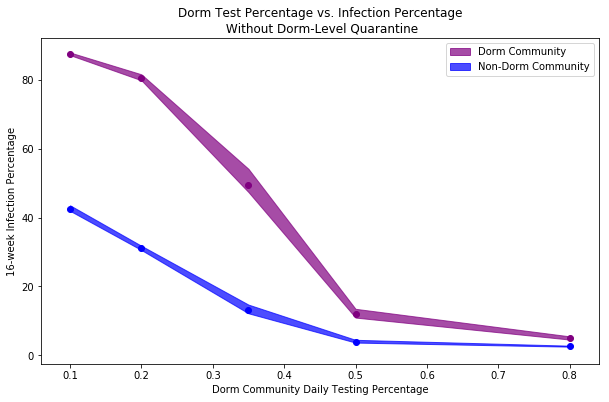

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(dorm_test_rates, avg_infections['dorm'], color='purple', marker='o')
plt.fill_between(dorm_test_rates, min_infections['dorm'], max_infections['dorm'], 
                 color='purple', alpha=0.7, label='Dorm Community')

plt.scatter(dorm_test_rates, avg_infections['non-dorm'], color='blue', marker='o')
plt.fill_between(dorm_test_rates, min_infections['non-dorm'], max_infections['non-dorm'], 
                 color='blue', alpha=0.7, label='Non-Dorm Community')
plt.legend(loc='best')

plt.xlabel("Dorm Community Daily Testing Percentage")
plt.ylabel("16-week Infection Percentage")

plt.title("Dorm Test Percentage vs. Infection Percentage\n Without Dorm-Level Quarantine")

plt.show()

In [24]:
import pickle
pickle.dump(quarantine_trajectories, open("dict_quarantine_trajectories_without_quarantine.pickle", "wb"))

In [25]:
import dill
dill.dump(dorm_sims, open("dict_dorm_sims_without_quarantine.pickle", "wb"))